In [31]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

## Group Assignment
### Team Number: 17
### Team Member Names: John, Gen, Tim
### Team Strategy Chosen: Risky 

Requirements for this assignment:
- Code needs to be dynamic
- Must read in a csv file containing a finite number of stock tickers (with an example csv file in this repo)
- Portfolio must contain only US listed stocks
- Must have an average daily volume of at least 10 000 shares as calculated based on the time interval July 2, 2021 to October 22, 2021
- Pick a minimum 10 maximum 20 stocks for portfolio.
- If we choose n stocks, each stock must make up minimum (100/(2n))% of the portfolio when weighted by value as of closing prices on November 26, 2021
- No individual stock may make up more than 35% of the portfolio when weighted by value
- We have $100000 USD to spend on portfolio and all must be spent
- When code is run with the .csv file, it must create a DataFrame "FinalPortfolio"
    - With this portfolio, index starts at 1 and ends at the number of stocks that our code chooses.
    - Headings must be: Ticker, Price, Shares, Value, Weight
        - Ticker is the ticker selected
        - Price is the price on November 26, 2021
        - Shares is the number of shares purchased (can be fractional)
        - Value is the total value of those shares
        - Weighted is the weight that the value of shares represents relative to the value of the portfolio (which is $100,000)
    - Needs to show that the total adds up to $100,000
    - Also need to show the weights add to 100%
    - This DataFrame must be printed to the screen as the second to last output to the screen.
- After the DataFrame, one final DataFrame called "Stocks" which has the same index as "Final Portfolio" must be mad
    - Only has the Tickers and Shares from "Final Portfolio"
    - Must output this DataFrame to a csv file titled "Stocks_Group_XX.csv"

### Define Important Global Variables (Optimizing Time and Memories)

In [32]:
# Import default information
start_date = "2021-07-02"
end_date = "2021-10-22"

# Stores the closing price of Tickers
all_price_df = pd.DataFrame()

### Step #1: Filter out valid US tickers

In [33]:
stocks_from_csv = pd.read_csv('Tickers.csv')
stocks_from_csv


,AAPL
0,ABBV
1,ABT
2,ACN
3,AGN
4,AIG
...,...
56,TXN
57,UNH
58,UNP
59,UPS


In [34]:
stocks_lst = stocks_from_csv.iloc[:,0]
stocks_lst

0     ABBV
1      ABT
2      ACN
3      AGN
4      AIG
      ... 
56     TXN
57     UNH
58     UNP
59     UPS
60     USB
Name: AAPL, Length: 61, dtype: object

In [35]:
stocks_from_csv.columns[0]

'AAPL'

In [36]:
current_stock=yf.Ticker(stocks_lst[0])
current_stock.info['market']

'us_market'

In [37]:
#try doing the process below with threading
from concurrent.futures import ThreadPoolExecutor, as_completed

us_stock_lst = []
stocks_lst
 
def filter_valid(ticker_name):
    try:
        ticker_yf = yf.Ticker(ticker_name) # Store as variable to optimize access time

        if (ticker_yf.info['regularMarketPrice'] != None) and (ticker_yf.info['market'] == 'us_market'):
            us_stock_lst.append(ticker_yf)
    
    except requests.exceptions.RequestException as e:
       return e
 
def runner():
    threads= []
    with ThreadPoolExecutor(max_workers=80) as executor:
        for name in stocks_lst:
            ticker = name
            threads.append(executor.submit(filter_valid, ticker))

runner()


In [38]:
us_stock_lst

[yfinance.Ticker object <ABT>,
 yfinance.Ticker object <GOOG>,
 yfinance.Ticker object <QCOM>,
 yfinance.Ticker object <NEE>,
 yfinance.Ticker object <TXN>,
 yfinance.Ticker object <CVS>,
 yfinance.Ticker object <ABBV>,
 yfinance.Ticker object <COST>,
 yfinance.Ticker object <AXP>,
 yfinance.Ticker object <MSFT>,
 yfinance.Ticker object <COF>,
 yfinance.Ticker object <GM>,
 yfinance.Ticker object <NKE>,
 yfinance.Ticker object <BA>,
 yfinance.Ticker object <SBUX>,
 yfinance.Ticker object <COP>,
 yfinance.Ticker object <MON>,
 yfinance.Ticker object <TGT>,
 yfinance.Ticker object <BAC>,
 yfinance.Ticker object <BIIB>,
 yfinance.Ticker object <T>,
 yfinance.Ticker object <JPM>,
 yfinance.Ticker object <C>,
 yfinance.Ticker object <PEP>,
 yfinance.Ticker object <MRK>,
 yfinance.Ticker object <BMY>,
 yfinance.Ticker object <AIG>,
 yfinance.Ticker object <AMZN>,
 yfinance.Ticker object <UNP>,
 yfinance.Ticker object <LMT>,
 yfinance.Ticker object <PYPL>,
 yfinance.Ticker object <PFE>,
 yfin

In [39]:
len(us_stock_lst)

54

### Step 2: Filter out tickers within date range based on daily average volume

In [40]:
# Define a list to store the valid tickers
valid_stock_list = []

# Finds the average daily volume of a stock
def avg_daily_volume(ticker):
    ticker_history = ticker.history(start=start_date,end=end_date,interval='1d')
    ticker_vol_avg = ticker_history['Volume'].mean()
    return ticker_vol_avg
    
    
# iterates through us_stock_lst and checks if the stock has an average daily volume of at least 10,000 shares and appends to a list
def volume_filter(ticker_lst):
    for i in us_stock_lst:
        if avg_daily_volume(i) >= 10_000:
            valid_stock_list.append(i)
        else:
            continue
    return valid_stock_list

filtered_stocks = volume_filter(us_stock_lst)
filtered_stocks

[yfinance.Ticker object <ABT>,
 yfinance.Ticker object <GOOG>,
 yfinance.Ticker object <QCOM>,
 yfinance.Ticker object <NEE>,
 yfinance.Ticker object <TXN>,
 yfinance.Ticker object <CVS>,
 yfinance.Ticker object <ABBV>,
 yfinance.Ticker object <COST>,
 yfinance.Ticker object <AXP>,
 yfinance.Ticker object <MSFT>,
 yfinance.Ticker object <COF>,
 yfinance.Ticker object <GM>,
 yfinance.Ticker object <NKE>,
 yfinance.Ticker object <BA>,
 yfinance.Ticker object <SBUX>,
 yfinance.Ticker object <COP>,
 yfinance.Ticker object <MON>,
 yfinance.Ticker object <TGT>,
 yfinance.Ticker object <BAC>,
 yfinance.Ticker object <BIIB>,
 yfinance.Ticker object <T>,
 yfinance.Ticker object <JPM>,
 yfinance.Ticker object <C>,
 yfinance.Ticker object <PEP>,
 yfinance.Ticker object <MRK>,
 yfinance.Ticker object <BMY>,
 yfinance.Ticker object <AIG>,
 yfinance.Ticker object <AMZN>,
 yfinance.Ticker object <UNP>,
 yfinance.Ticker object <LMT>,
 yfinance.Ticker object <PYPL>,
 yfinance.Ticker object <PFE>,
 yfin

In [41]:
len(filtered_stocks)

54

### Step #3 Obtain the 20 most volatile stocks from the filtered lsit

In [42]:
def find_volatile (stock_count, ticker_lst, start_date, end_date): #Stock count will most likely be 20 #ticker_lst will always be filtered_stocks
    #Get the stock history
    stock_history = []
    for y in range (len (ticker_lst)):
        stock_history.append(ticker_lst[y].history(start=start_date, end=end_date))
    
    #Monthly Closing Prices dataframe
    monthly_close = []
    for g in range (len(stock_history)):
        monthly_close.append(pd.DataFrame(stock_history[g]['Close']))
    
    #Combine the individual stocks together to make one large dataframe
    share_prices = pd.concat (monthly_close, join='inner', axis=1)

    # Rename the columns (will need to fix this soon)
    share_prices.columns = ticker_lst

    #Convert our dataframe into simply one column with standard deviation 
    sd_of_shares = share_prices.pct_change().std()

    #Have to convert sd_of_shares into a dataframe
    sd_df = pd.DataFrame(sd_of_shares)

    #Find the 20 largest standard deviations meaning the most volatile
    column = sd_df[0]
    largest_names = []
    for g in range (stock_count):
        largest_names.append(column.idxmax().info['symbol'])
        column = column.drop([column.idxmax()])

    return largest_names

largest_volatile = find_volatile(20, filtered_stocks, '2021-07-02', '2021-10-22')    

In [43]:
largest_volatile

['OXY',
 'SLB',
 'GM',
 'COP',
 'COF',
 'BA',
 'PYPL',
 'AIG',
 'SPG',
 'BIIB',
 'BAC',
 'USB',
 'KMI',
 'BK',
 'AXP',
 'CAT',
 'MS',
 'PFE',
 'AMZN',
 'CMCSA']

In [44]:
len(largest_volatile)

20

### Step #4: Find the porfolio with the best correlation

In [45]:
### Add all data for tickers to a global price dataframe: all_price_df
def update_price_df(ticker_lst, start_date, end_date):
    # Load the global dataframe
    global all_price_df
    
    # Read in the history closing price info
    # Store in a dictionary where the key is the name of the ticker
    hist_dic = {}
    for i in ticker_lst:
        if i not in all_price_df:
            ticker_yf = yf.Ticker(i)
            hist_dic[i] = ticker_yf.history(start=start_date, end=end_date)['Close']
    
    # Convert the dictionary to a dataframe
    temp_price_df = pd.DataFrame(hist_dic)
    
    # If there is tickers to add, then resample it to month and add to the global closing price df
    if not temp_price_df.empty:
        # temp_prices_df = prices_df.resample('MS').first()
        all_price_df = pd.concat([all_price_df, temp_price_df], axis=1)

In [46]:
### Find all possible combinations of n tickers within the ticker_lst using a recursive function
def combinations(arr, length, pre_arr=[]):
    if len(pre_arr) == length:
        return [pre_arr]
    
    combs = []
    # Add each element to the previous array
    for i, val in enumerate(arr):
        cur_copy = pre_arr.copy()
        cur_copy.append(val)
        combs += combinations(arr[i+1:], length, cur_copy)
    return combs

In [47]:
### Find the average correlation between each stock
def find_avg_corr(ticker_lst, start_date, end_date):
    # Load the global price dataframe
    global all_price_df
    
    # Find the dataframe with the given tickers and filter the dates
    price_df = all_price_df[ticker_lst]
    price_df = price_df[(start_date <= price_df.index) & (price_df.index <= end_date)]
    
    # Find the correlation matrix
    df_corr = price_df.corr()
    
    # Calculate the avg corr
    sum_corr = 0
    sum_count = 0
    for i in range (len(ticker_lst)):
        for j in range (i+1, len(ticker_lst)):
            sum_corr += df_corr.loc[ticker_lst[i],ticker_lst[j]]
            sum_count += 1
    
    # Calculate the return the avg correlation
    return sum_corr/sum_count

In [48]:
# Find the combinaton of tickers with the maximum avg correlation
def find_max_correlation(ticker_lst,  start_date, end_date, result_size = 10):
    # Store the maximum value of corr and the portfolio
    max_avg_corr = -1
    max_corr_ticker_lst = np.array([])
    
    # Load the global price dataframe
    global all_price_df
    
    # Convert list to array and find the combinations
    comb = combinations(np.array(ticker_lst), result_size)
    
    # Find the comb with the maximum average correlation
    for i in comb:
        avg_corr = find_avg_corr(i, start_date, end_date)
        if avg_corr > max_avg_corr:
            max_avg_corr = avg_corr
            max_corr_ticker_lst = i
    
    # Return the result sample
    return max_avg_corr, max_corr_ticker_lst

In [49]:
### Applying the functions
# A random ticker list
ticker_lst = largest_volatile[0:17] # Only take the first 16

# Update the global closing df
update_price_df(ticker_lst, start_date, end_date)

# Find the combination of tickers with maximum correlation
max_avg_corr, max_corr_ticker_lst = find_max_correlation(ticker_lst, start_date, end_date)

# Display
print('The maximum avg correlation is:', max_avg_corr)
print('The portfolio with maximum avg correlation is:', max_corr_ticker_lst)


The maximum avg correlation is: 0.6005159116457597
The portfolio with maximum avg correlation is: ['OXY', 'SLB', 'COP', 'COF', 'AIG', 'SPG', 'BAC', 'USB', 'BK', 'AXP']


### Step 5 Given a list of stocks, find the best distributions of the weight

In [50]:
### Define important variables
ticker_count = len(max_corr_ticker_lst)

min_weight = 1/(2*ticker_count)
max_weight = 0.35
increment = 0.0625 # would run through 8^10 cases
# Use increment = 0.10 would be much faster
# Code only works for when ticker_count is 10

In [51]:
### Define a function for portfolio calculations
def portfolio_cal(tickers, weights, start_date, end_date, investment=100000):
    # Load the global variable price dataframe
    global all_price_df
    
    # Store the size of tickers as a variable
    ticker_count = len(tickers)
    
    # Store the number of shares purchased for each stock in a dictionary 
    shares_dic = {}
    
    # Calculate the shares for each stock at the first avaliable date after start_date
    first_date = all_price_df.index[all_price_df.index >= start_date][0]
    for i in range (ticker_count):
        shares_dic[tickers[i]] = (investment * weights[i] / all_price_df.loc[first_date, tickers[i]])

    # Store the portfolio value in a new dataframe, starting with all zeros
    port_value = pd.DataFrame()
    
    # Calculate the value of each stock to the portfolio
    for i in range (ticker_count):
        shares = shares_dic[tickers[i]]
        port_value[str(tickers[i])] = all_price_df[tickers[i]] * shares
    
    # Find the range of values within the dates
    port_value = port_value[(start_date <= port_value.index) & (port_value.index <= end_date)]
    
    # Calculate the percentage returns
    port_value['Portfolio_Value'] = port_value[tickers].sum(axis=1)
    
    # Calculate percentage returns
    port_value['Percent_Return'] = port_value['Portfolio_Value'].pct_change() * 100
    
    return port_value[['Portfolio_Value', 'Percent_Return']]

In [52]:
### Iterate through possibilities of weight to find the max Std
# Define variables
all_std = []
max_std = -1
optimal_weights = []
check_count = 0

# Recursion: returns weight with max std, and list of all stds
def find_weight(t_count, cur_index, weights, acc_weight):
    # Load global varables
    global all_std, max_std, optimal_weights, check_count
    
    # If the acc_weight is already over 1, ends recursion
    if (acc_weight > 1): return
    
    # Already assigned last ticker's weights
    if (cur_index == t_count):
        # If the acc_weight is not 1, then invalid distribution and no calculation
        if (acc_weight != 1): return
        
        # Display for confirmation that code works
        check_count += 1
        if (check_count % 10000 == 0): print(f'Already Checked {check_count} Weighting Distributions.')

        # Calculate portfolio Std
        port_df = portfolio_cal(max_corr_ticker_lst, weights, start_date, end_date)
        std = port_df['Percent_Return'].std()
        
        # Store and find max std
        all_std.append(std)
        if (std > max_std):
            max_std = std
            optimal_weights = weights
        
        # End recursion since this is last index (aka last ticker to assign weights)
        return
    
    # Assign weighting for this stock 
    cur_weight = min_weight
    while (cur_weight <= max_weight):
        # Recursively call for next index
        find_weight(t_count, cur_index + 1, weights + [cur_weight], acc_weight+cur_weight)
        cur_weight = round (cur_weight + increment, 5)

# Use the function to find std info
find_weight(ticker_count, 0, [], 0)

In [53]:
print('The highest recorded std is', max_std)
print('The ticker in the portfolio and corresponding weights:')
max_corr_ticker_lst, optimal_weights

The highest recorded std is 11.488682772831966
The ticker in the portfolio and corresponding weights:


(['OXY', 'SLB', 'COP', 'COF', 'AIG', 'SPG', 'BAC', 'USB', 'BK', 'AXP'],
 [0.3, 0.05, 0.05, 0.05, 0.05, 0.05, 0.3, 0.05, 0.05, 0.05])

### Step 6 Graph the portfolio standard deviation for different weightings

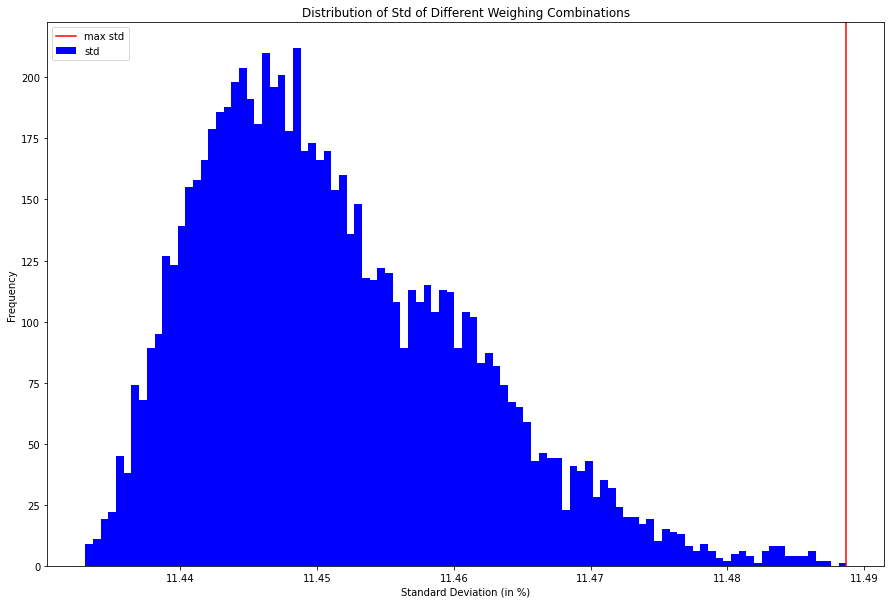

In [60]:
### Use a histogram to show the std of other weightings
# Create the interval classes
bins_max = max(all_std)
bins_min = min(all_std)
bins_intervals = 100
bins = np.linspace(bins_min, bins_max, bins_intervals)

# Create the histogram
plt.rcParams["figure.figsize"] = (15,10)
plt.hist(all_std, bins, color='b', label='std')
plt.axvline(x=max_std, color='r', label='max std')

# Formatting
plt.title("Distribution of Std of Different Weighing Combinations")
plt.xlabel("Standard Deviation (in %)")
plt.ylabel("Frequency")
plt.legend(loc='best')

# Display
plt.show()

### Step 7 Given the chosen portfolio, measure its performance against the price weighted index consisting of all filtered US Stocks in Step 2

### Step 8 Given the chosen portfolio of 10 stocks, graph the change in portfolio standard deviation as other risky stocks (from the 10 that weren’t chosen in Step 4) are added in

In [ ]:
### Create the output as required
final_tickers = max_corr_ticker_lst
final_weights = optimal_weights
investment = 1000000
required_date = '2021-11-11'
next_date = '2021-11-12'
# Get the price, share, value, weight of the ticker on required date 
value = [] 
for i in range (len(final_tickers)): 
    value.append(investment * final_weights[i])
    

# Create a diction to store the required info
final_dic = {'Ticker' : final_tickers,
             'Price'  : price,
             'Shares' : share,
             'Value'  : value,
             'Weight' : weight}

In [ ]:
#Graphing portion
#graph out the standard deviation
plt.figure(figsize=(20,15))

plt.plot(['1 industry','2 industries', '3 industries', '4 industries', '5 industries', '6 industries', '7 industries', '8 industries', '9 industries', '10 industries'],SD, color='b', label='Standard Deviation')
plt.legend(loc='best')
plt.title('Standard Deviation of the Percentage Return as more stocks are added')
plt.xlabel('Number of Industries')
plt.ylabel('Standard Deviation')

plt.show()

### Step 9 Creating the final portfolio with csv

In [61]:
# Access the price on the required date
def price_on_date(ticker, date, next_date):
    return yf.Ticker(ticker).history(start=date, end=next_date)[['Close']].iloc[0,0]

In [62]:
### Create the output as required
final_tickers = max_corr_ticker_lst
final_weights = optimal_weights
investment = 1000000
required_date = '2021-11-11'
next_date = '2021-11-12'

# Get the price, share, value, weight of the ticker on required date
price = []
value = []
share = []
weight = []
for i in range (len(final_tickers)):
    price.append(price_on_date(str(final_tickers[i]), required_date, next_date))
    value.append(investment * final_weights[i])
    share.append(value[i] / price[i])
    weight.append(final_weights[i] * 100)
    

# Create a diction to store the required info
final_dic = {'Ticker' : final_tickers,
             'Price'  : price,
             'Shares' : share,
             'Value'  : value,
             'Weight' : weight}

# Create the final df
FinalPortfolio = pd.DataFrame(final_dic)
# Shift the index
FinalPortfolio.index = np.arange(1, len(FinalPortfolio)+1)

# Display
FinalPortfolio

,Ticker,Price,Shares,Value,Weight
1,OXY,32.119999,9339.975404,300000.0,30.0
2,SLB,32.779999,1525.320374,50000.0,5.0
3,COP,72.139999,693.096762,50000.0,5.0
4,COF,156.549988,319.386802,50000.0,5.0
5,AIG,58.860001,849.473318,50000.0,5.0
6,SPG,165.440002,302.224367,50000.0,5.0
7,BAC,47.490002,6317.119170,300000.0,30.0
8,USB,60.779999,822.639043,50000.0,5.0
9,BK,59.990002,833.472222,50000.0,5.0
10,AXP,181.300003,275.785985,50000.0,5.0


## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Insert Names Here. 